In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from scipy.linalg import solve_discrete_lyapunov

from tqdm import trange

sys.path.append('../')

from examples.test_lds import main
from evaluations import gaussian_cdf_evaluation_PF, gaussian_cdf_evaluation_KF
from kalman_filtering import KalmanFilter, kalman_filtering_without_control
from environment_dynamics import LDSSimple

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [14]:
true_state_history, estimate_state_history, particle_history, weight_history, obs_history = main(
    seed=2, save_particles=True, num_iters=1000, init="gaussian", num_particles=5000)

In [17]:
len(true_state_history)

1000

In [18]:
theta = np.pi / 12
A = 0.99 * np.array([
[np.cos(theta), -np.sin(theta)], 
[np.sin(theta), np.cos(theta)], 
])
C = np.eye(2)

Sigma = np.eye(2) * 1.0
Gamma = np.eye(2) * 0.5

mu0 = np.array([10., 0.])
Gamma0 = np.eye(2) * 1.0

kf = KalmanFilter(A, C, Gamma, Sigma)

mu, V = kf.filtering(np.array(obs_history))

In [183]:
np.array(estimate_state_history).shape

(20, 2)

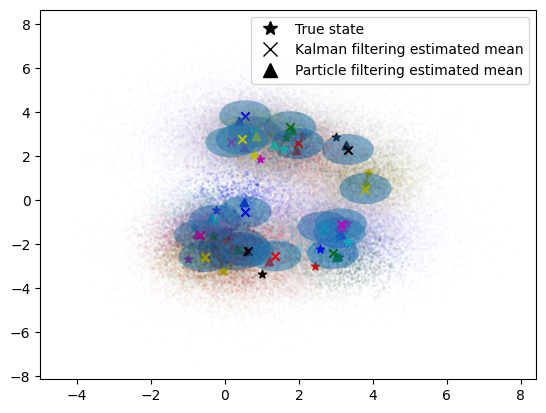

In [11]:
colors = 'rgbcmyk'

h = plt.subplot()

for i in range(20):
    plt.scatter(particle_history[i][:, 0], particle_history[i][:, 1], s=1, marker="x", label=str(i), alpha=0.01, color=colors[i%len(colors)])
    plt.scatter(np.array(true_state_history)[i, 0], np.array(true_state_history)[i, 1], color=colors[i%len(colors)], marker="*")
    plt.scatter(np.array(estimate_state_history)[i, 0], np.array(estimate_state_history)[i, 1], marker="^", color=colors[i%len(colors)])
    
    eigenvalues, eigenvectors = np.linalg.eigh(V[i])
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    ellipse = mpl.patches.Ellipse(xy=mu[i, :], width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]), angle=angle)
    ellipse.set_alpha(0.5)
    h.add_artist(ellipse)
    plt.scatter(mu[i, 0], mu[i, 1], marker="x", color=colors[i%len(colors)])

true_states_patch = mlines.Line2D([], [], color='k', marker='*', linestyle='None',
                          markersize=10, label='True state')
particle_filtering_estimate_patch = mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Kalman filtering estimated mean')
kalman_filtering_estimate_patch = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=10, label='Particle filtering estimated mean')
plt.legend(handles=[true_states_patch,particle_filtering_estimate_patch,kalman_filtering_estimate_patch])
# plt.savefig("../figures/evaluate_filtering_viz.pdf")

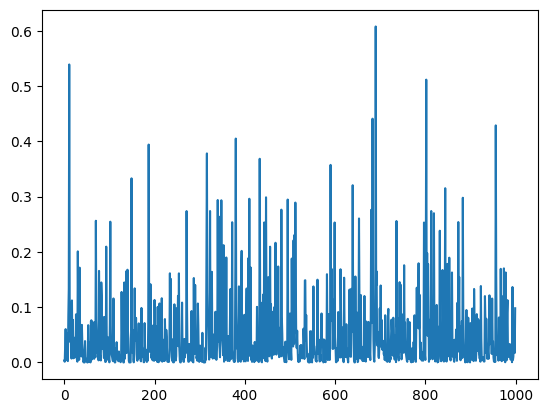

In [19]:
plt.plot(np.sum(np.square(mu - np.array(estimate_state_history)), axis=-1))
# plt.savefig("../figures/KF_PF_squared_difference.pdf")

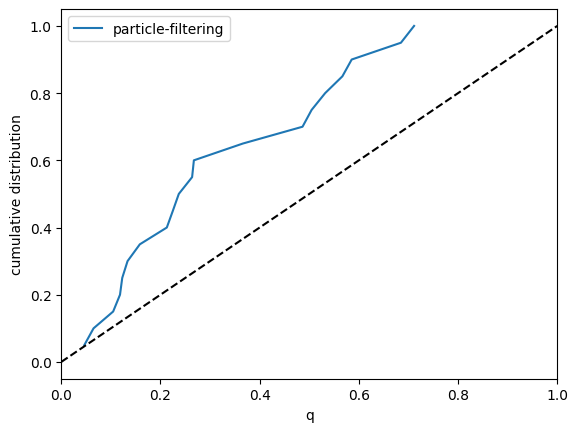

In [98]:
gaussian_cdf_evaluation_PF(particle_history, true_state_history, weight_history)

In [45]:
theta = np.pi / 12
A = 0.99 * np.array([
[np.cos(theta), -np.sin(theta)], 
[np.sin(theta), np.cos(theta)], 
])
C = np.eye(2)

Sigma = np.eye(2) * 1.0
Gamma = np.eye(2) * 0.5

mu0 = np.array([10., 0.])
Gamma0 = np.eye(2) * 1.0

kf = KalmanFilter(A, C, Gamma, Sigma)

In [46]:
mu, V = kf.filtering(np.array(obs_history))

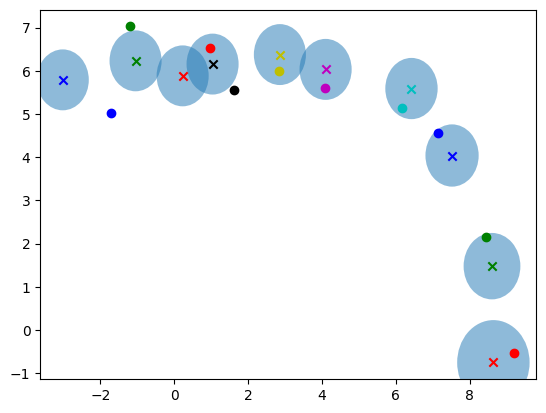

In [47]:
colors = 'rgbcmyk'
h = plt.subplot()
for i in range(10):
    eigenvalues, eigenvectors = np.linalg.eigh(V[i])
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    ellipse = mpl.patches.Ellipse(xy=mu[i, :], width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]), angle=angle)
    ellipse.set_alpha(0.5)
    h.add_artist(ellipse)
    plt.scatter(mu[i, 0], mu[i, 1], marker="x", color=colors[i%len(colors)])
    plt.scatter(np.array(true_state_history)[i, 0], np.array(true_state_history)[i, 1], color=colors[i%len(colors)])

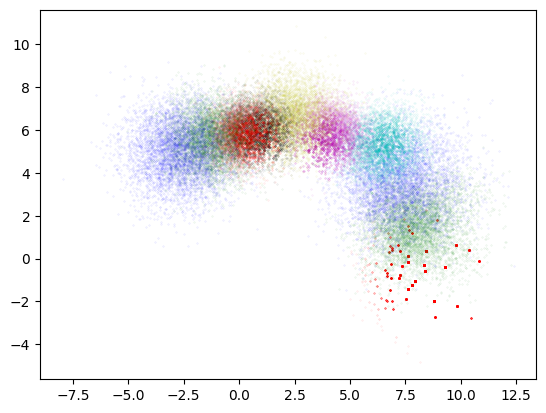

In [71]:
colors = 'rgbcmyk'



plt.scatter(mu[:, 0], mu[:, 1])
plt.scatter(np.array(true_state_history)[:, 0], np.array(true_state_history)[:, 1], marker="x")

for i in range(10):
    eigenvalues, eigenvectors = np.linalg.eigh(V[i])
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    ellipse = mpl.patches.Ellipse(xy=mu[i, :], width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]), angle=angle)
    ellipse.set_alpha(0.5)
    h.add_artist(ellipse)
    
    plt.scatter(particle_history[i][:, 0], particle_history[i][:, 1], s=1, marker="x", label=str(i), alpha=0.05, color=colors[i%len(colors)])
    # plt.scatter(np.array(true_state_history)[i, 0], np.array(true_state_history)[i, 1], color=colors[i%len(colors)])

In [20]:
particle_history, weight_history, true_state_history = [], [], []
with trange(50, dynamic_ncols=True) as pbar:
    for i in pbar:
        true_state_history_temp, estimate_state_history, particle_history_temp, weight_history_temp, obs_history = main(save_particles=True, init="gaussian", 
                                                                                                                        num_iters=20, num_particles=5000)
        particle_history.append(particle_history_temp)
        weight_history.append(weight_history_temp)
        true_state_history.append(true_state_history_temp)
particle_history = np.concatenate(particle_history, axis=0)
weight_history = np.concatenate(weight_history, axis=0)
true_state_history = np.concatenate(true_state_history, axis=0)

100%|██████████| 50/50 [04:16<00:00,  5.13s/it]


In [4]:
true_state_history

array([[-8.41569763,  6.34747917],
       [-8.93459451,  4.11161182],
       [-9.91513416,  2.56100624],
       ...,
       [-5.57227882,  0.60623819],
       [-5.96292416, -0.76041512],
       [-5.75163699, -2.90436907]])

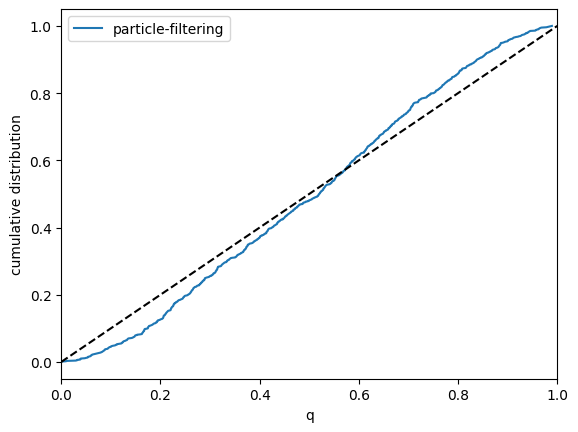

In [25]:
gaussian_cdf_evaluation_PF(particle_history, true_state_history, weight_history, dim=0)

In [143]:
true_state_history.shape

(500, 2)

In [37]:
np.linalg.eig(A)

(array([0.96592583+0.25881905j, 0.96592583-0.25881905j]),
 array([[ 0.        -0.70710678j,  0.        +0.70710678j],
        [-0.70710678+0.j        , -0.70710678-0.j        ]]))

In [31]:
theta = np.pi / 12
A = 0.99 * np.array([
[np.cos(theta), -np.sin(theta)], 
[np.sin(theta), np.cos(theta)], 
])
C = np.eye(2)

Sigma = np.eye(2) * 1.0
Gamma = np.eye(2) * 0.5

init_KF_kwargs = {
    "A": A, 
    "C": C, 
    "Sigma": Sigma, 
    "Gamma": Gamma, 
}

# mu0 = np.array([10., 0.])
# Gamma0 = np.eye(2) * 1.0
mu0 = None
Gamma0 = None
# mu0 = np.zeros((2, ))
# Gamma0 = solve_discrete_lyapunov(A, Gamma)

init_env_kwargs = {
    "A": A, 
    "C": C, 
    "Sigma": Sigma, 
    "Gamma": Gamma, 
    "mu0": mu0, 
    "Gamma0": Gamma0, 
}

true_state_history_KF = []
KF_mu_history = []
KF_cov_history = []

for i in range(1000):
    mu, V, true_state = kalman_filtering_without_control(
        1000, 
        env_cls=LDSSimple, 
        init_env_kwargs=init_env_kwargs, 
        init_KF_kwargs=init_KF_kwargs, 
    )
    
    true_state_history_KF.append(true_state)
    KF_mu_history.append(mu)
    KF_cov_history.append(V)

true_state_history_KF = np.array(true_state_history_KF)
KF_mu_history = np.array(KF_mu_history)
KF_cov_history = np.array(KF_cov_history)

In [33]:
cdf = []
with trange(1000, dynamic_ncols=True) as pbar:
    for i in pbar:
# for i in range(1000):
        cdf.append(gaussian_cdf_evaluation_KF(
            KF_mu_history[i], 
            KF_cov_history[i], 
            true_state_history_KF[i], 
            dim=1, 
        ))

cdf = np.array(cdf).flatten()
sorted_cdf = np.sort(cdf)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


In [155]:
KF_mu_history[i].shape

(20, 2)

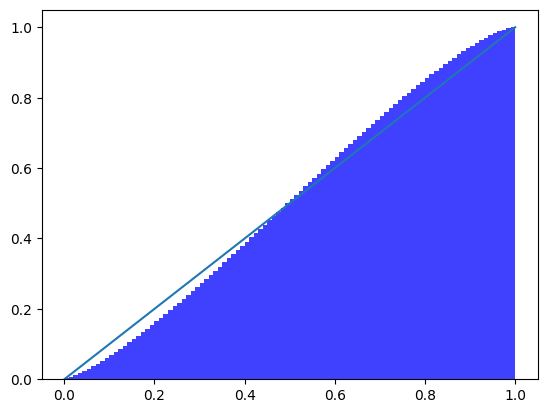

In [34]:
fig, ax = plt.subplots(1, 1)
ax.hist(cdf, bins=100, cumulative=True, density=True, alpha=0.75, color='blue')
ax.plot([0, 1], [0, 1])
# gaussian_cdf_evaluation_PF(particle_history, true_state_history, weight_history, ax=ax, dim=1)

In [110]:
ecdf = np.cumsum(np.ones_like(sorted_cdf)) / len(cdf)

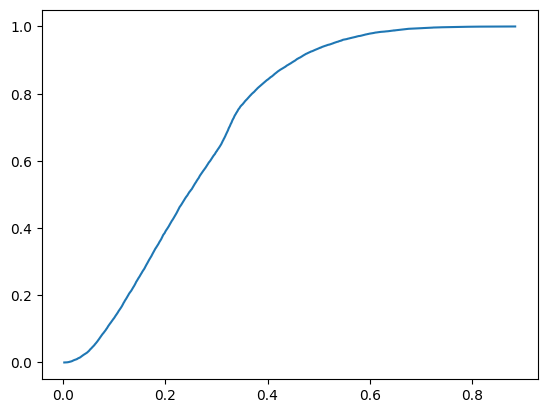

In [111]:
plt.plot(sorted_cdf, ecdf)

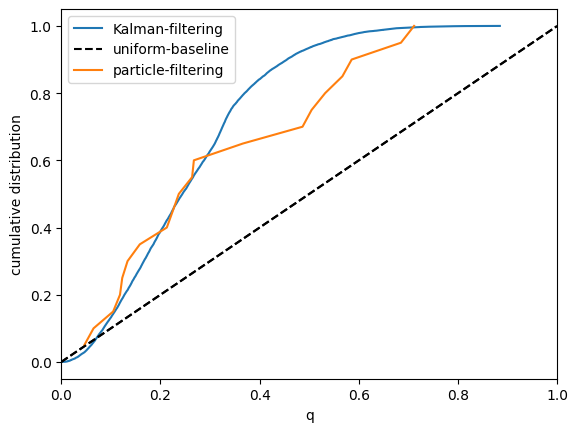

In [128]:
fig, ax = plt.subplots()
ax.plot(sorted_cdf, ecdf, label="Kalman-filtering")
ax.plot(np.arange(1000) / 1000, np.arange(1000)* 0.001, "k--", label="uniform-baseline")
gaussian_cdf_evaluation_PF(particle_history, true_state_history, weight_history, ax=ax)

ax.legend()

fig.savefig("../figures/evaluate_filtering_cdf.pdf")

In [25]:
np.cumsum(np.sort(cdf)) / np.sum(cdf)

array([2.87490781e-04, 7.30906242e-04, 1.20053789e-03, 1.68960792e-03,
       2.25651564e-03, 3.63828095e-03, 5.15031690e-03, 6.74227161e-03,
       8.48844253e-03, 1.05420184e-02, 1.09687285e-02, 1.14565258e-02,
       1.19682602e-02, 1.26459562e-02, 1.33870963e-02, 1.41872510e-02,
       1.50632601e-02, 1.62978599e-02, 1.77138853e-02, 1.94366086e-02,
       1.99226208e-02, 2.05888651e-02, 2.13765823e-02, 2.23325751e-02,
       2.33792015e-02, 2.44534099e-02, 2.57161117e-02, 2.73750698e-02,
       2.91212475e-02, 3.14273795e-02, 3.16680901e-02, 3.20201694e-02,
       3.23823733e-02, 3.27931639e-02, 3.32771875e-02, 3.37617935e-02,
       3.42701895e-02, 3.50683181e-02, 3.63779663e-02, 3.78926826e-02,
       3.84222898e-02, 3.91918325e-02, 3.99646675e-02, 4.09627621e-02,
       4.20876701e-02, 4.33182920e-02, 4.46153831e-02, 4.61089298e-02,
       4.77260894e-02, 4.94231681e-02, 4.96902310e-02, 5.00530662e-02,
       5.04683561e-02, 5.09047914e-02, 5.14830647e-02, 5.21676601e-02,
      